# WWW-COURSERA-DOWNLOADER

Originally created by Jansen Simanullang, 2018.

My previous version of `www-coursera-downloader` dated back from 2016 is no longer working.

Sorry for the frustation of many people who have download my previous `www-coursera-downloader` and cannot use it.


## A. Requirements

### (1) Install Geckodriver
Install Geckodriver from : https://github.com/mozilla/geckodriver/releases/

#### Check Geckodriver version

In [2]:
!echo == GECKODRIVER ==:
!geckodriver --version

== GECKODRIVER ==:
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### (2) Install Some Python Packages

In [3]:
!pip install -q bs4 splinter jupyter_contrib_nbextensions

In [47]:
from splinter import Browser
import base64, os, sys, requests, time
from bs4 import BeautifulSoup

## B. Definitions

### B. 1 Some constants

In [5]:
# adjust loading+time to your network speed~!
loading_time = 10

In [6]:
homepage='https://www.coursera.org'

In [7]:
resolution = {'low':'360','med':'540','hi':'720'}
# adjust chosen_res to your liking
chosen_res = 'hi'

### B.2 Helper Function 

In [8]:
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

In [9]:

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    import os
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():
    import json
    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    import os
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():
    import getpass, os
    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

In [96]:
def get_mp4_url(lesson_url):
    browser.visit(homepage+lesson_url)
    print('video playing will be paused in ' + str(loading_time) + ' seconds...')
    time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

In [92]:
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    file_name = lesson_id +'-'+ lesson_title + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('file already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')
    

## C. Coursera

### Login Page

In [12]:
browser = Browser('firefox', headless = True)

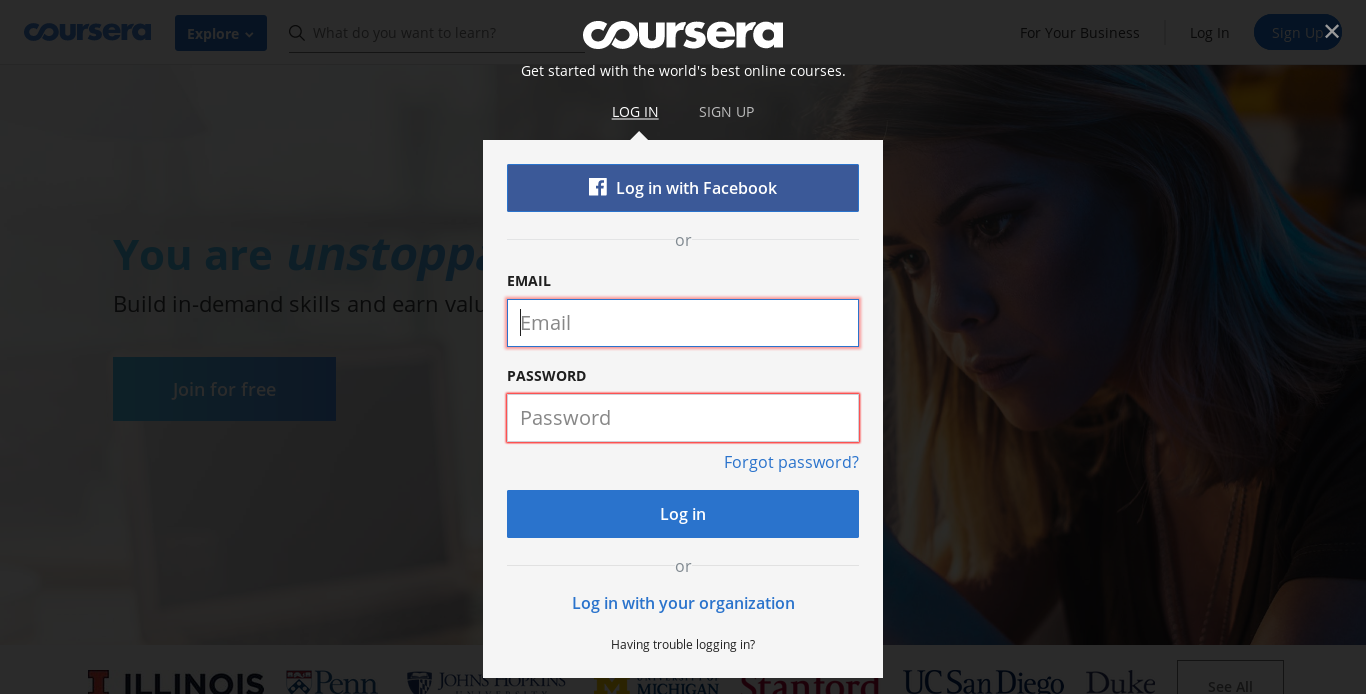

In [13]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

### Insert Login Credential

In [14]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [15]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [16]:
browser.fill('email', username)
browser.fill('password', password)

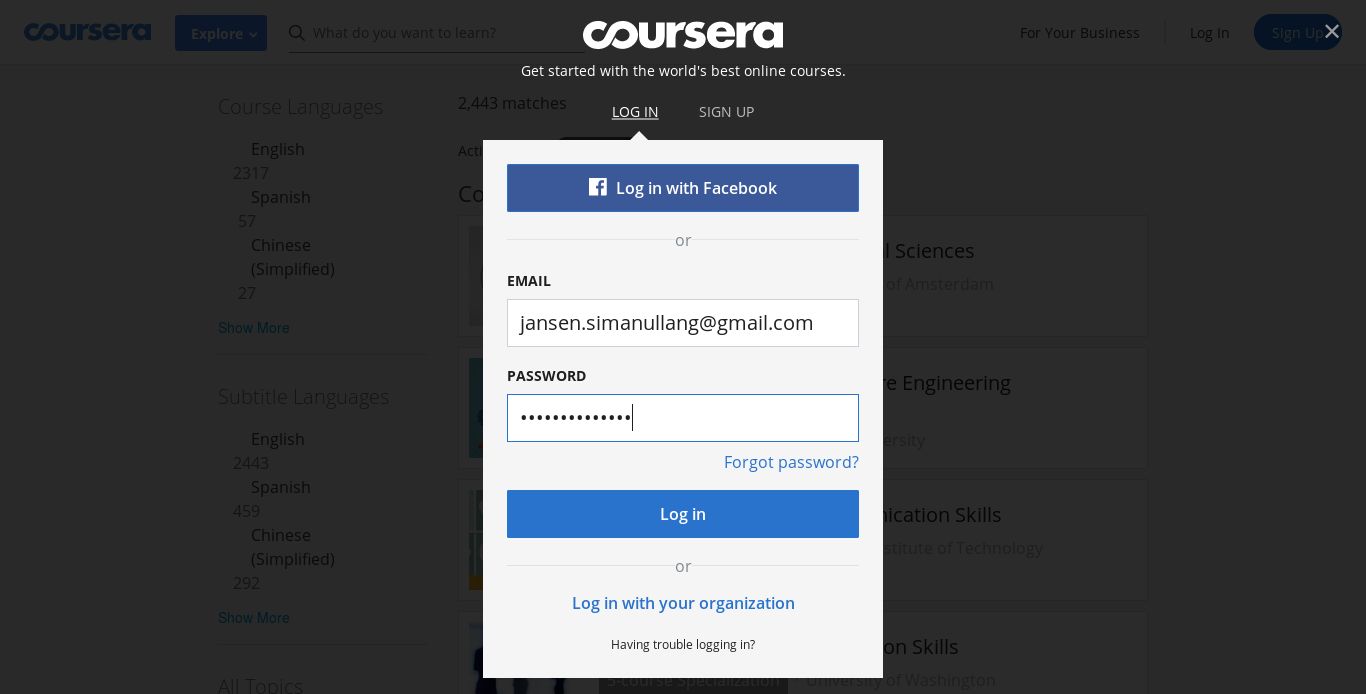

In [17]:
screenshot()

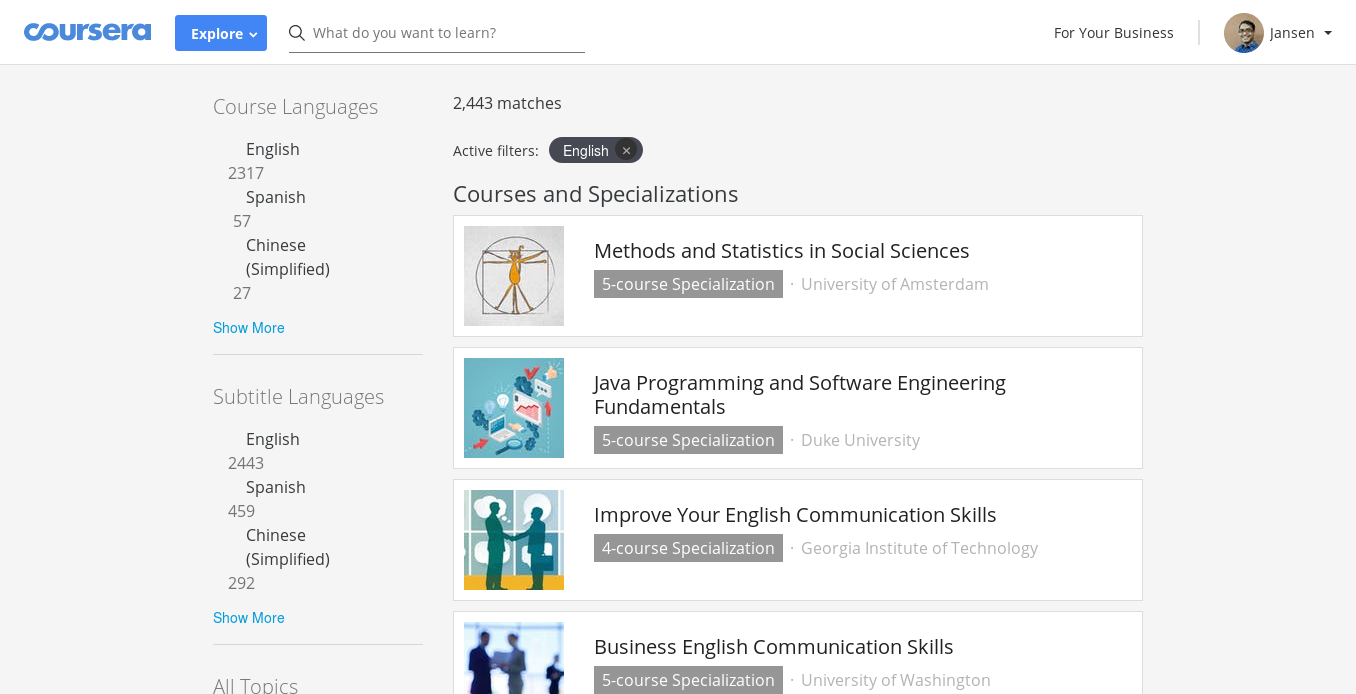

In [18]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break
screenshot()

### LAST ACTIVE COURSES

In [19]:
browser.visit(homepage)
section = browser.find_by_tag('section')
titles = []

for s in section:
    title = s.find_by_tag('h4').text
    titles.append(title)
    
for i, title in enumerate(titles):
    print(i+1, title)

1 Control of Mobile Robots
2 Structuring Machine Learning Projects
3 Neural Networks and Deep Learning
4 Convolutional Neural Networks
5 Microservices - Fundamentals
6 Developing and Deploying Microservices with Microclimate
7 How Google does Machine Learning
8 Software Architecture
9 Version Control with Git
10 Digital Product Management: Modern Fundamentals
11 Exploratory Data Analysis
12 Exploratory Data Analysis
13 Reproducible Research


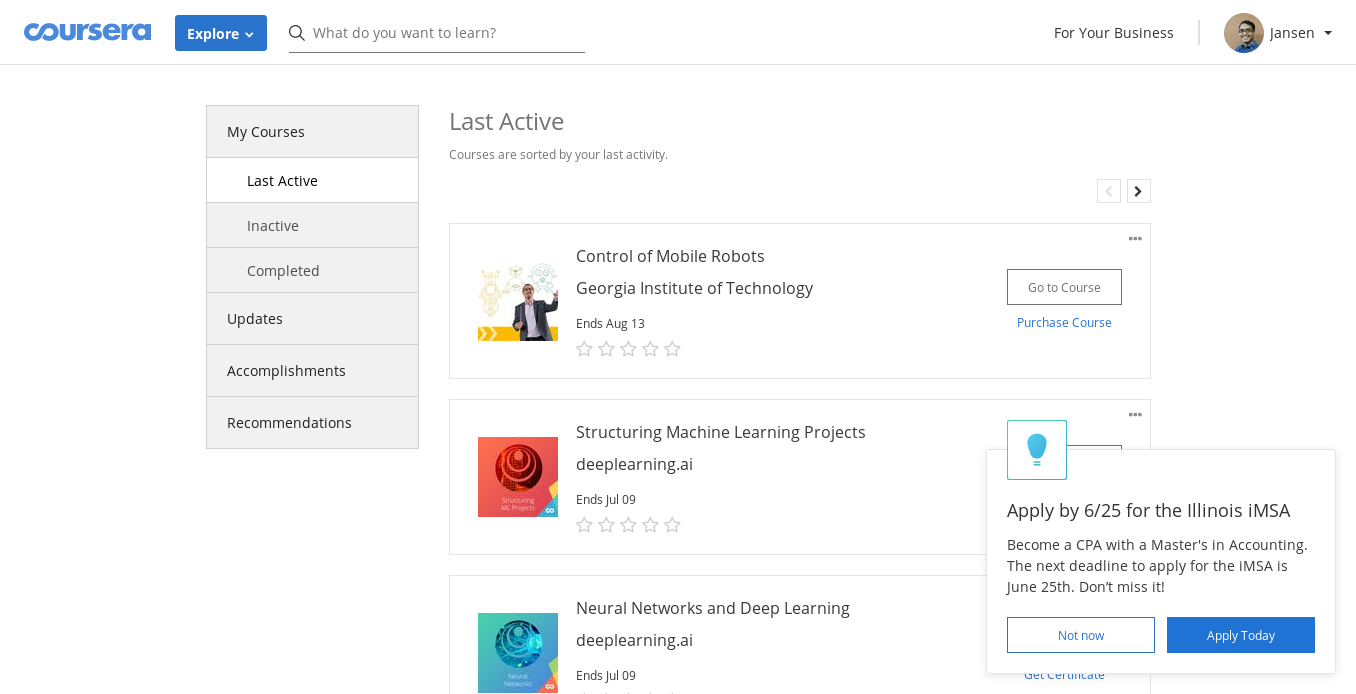

In [20]:
screenshot()

There are {{len(titles)}} courses visible in this section you can pick to download.

### PICK ONE OF THE COURSES and edit here

In [ ]:
# Pick one of the courses by number
#  chosen_course = int(input('Pick one of the courses by number'))
chosen_course = 1 #<--- edit here 
section[chosen_course-1].click()
course_title = titles[chosen_course-1]

 ### {{ titles[chosen_course-1] }}

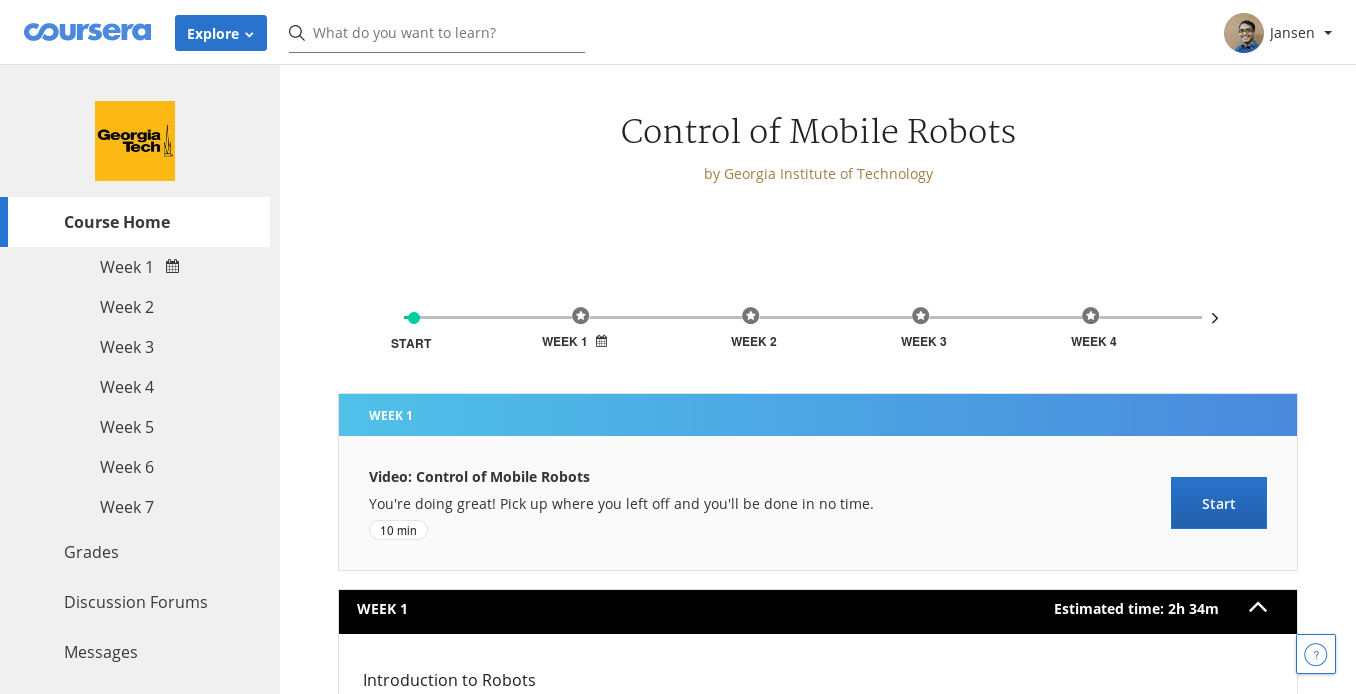

In [22]:
screenshot()

In [23]:
lecture_homepage = browser.driver.current_url

'https://www.coursera.org/learn/mobile-robot/home/welcome'

In [24]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/mobile-robot/home/week/1',
  '/learn/mobile-robot/home/week/2',
  '/learn/mobile-robot/home/week/3',
  '/learn/mobile-robot/home/week/4',
  '/learn/mobile-robot/home/week/5',
  '/learn/mobile-robot/home/week/6',
  '/learn/mobile-robot/home/week/7'],
 7)

In [85]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    
    w = w+1
    
    print('\nVisiting week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    
    print()    
    print('Week '+str(w)+' titles:')
    lessons_title = module_lessons.find_by_tag('h5')
    for j, l in enumerate(lessons_title):
        lesson_id = str(w*100+j+1).zfill(3)
        title = l.text.replace('\n',' ')
        print(lesson_id, title)
        lessons_t.append(title)
        lessons_i.append(lesson_id)
    
    print()    
    print('Week '+str(w)+' links:')    
    lessons_url = module_lessons.find_by_tag('ul')
    anchors = BeautifulSoup(lessons_url.html, 'lxml').findAll('a')

    for j, a in enumerate(anchors):
        lesson_id = str(w*100+j+1).zfill(3)
        lesson_url = a['href']
        print(lesson_id, lesson_url)
        lessons_u.append(a['href'])
        
    print()

collecting lessons title and urls...


Visiting week: 1

Week 1 titles:
101 Reading Getting Started
102 Lecture Control of Mobile Robots
103 Reading Preparing for Programming Assignments
104 Lecture What's Control Theory, Anyway?
105 Lecture On the Need for Models
106 Lecture Cruise-Controllers
107 Lecture Control Design Basics
108 Lecture Performance Objectives
109 Lecture PID Control
110 Lecture Implementation
111 Lecture Glue Lecture 1
112 Quiz: Quiz 1
113 Lecture Programming & Simulation Lecture 1
114 Reading Optional Programming Assignment 1: Instructions
115 Reading Get More From Georgia Tech
116 Reading Module 1 Lecture Slides
117 Reading MATLAB Tutorials

Week 1 links:
101 /learn/mobile-robot/supplement/JwbMm/getting-started
102 /learn/mobile-robot/lecture/7hOaW/control-of-mobile-robots
103 /learn/mobile-robot/supplement/ZEuFm/preparing-for-programming-assignments
104 /learn/mobile-robot/lecture/F0onc/whats-control-theory-anyway
105 /learn/mobile-robot/lecture/sQrd6/on-the-need


Visiting week: 7

Week 7 titles:
701 Lecture Approximations and Abstractions
702 Lecture A Layered Architecture
703 Lecture Differential-Drive Trackers
704 Lecture A Clever Trick
705 Lecture Other Robot Classes
706 Lecture Car-Like Robots
707 Lecture To Probe Further
708 Lecture In Conclusion
709 Lecture Glue Lecture 7
710 Quiz: Quiz 7
711 Lecture Programming & Simulation Lecture 7
712 Reading Optional Programming Assignment 7: Instructions
713 Reading Module 7 Lecture Slides

Week 7 links:
701 /learn/mobile-robot/lecture/yrCPw/approximations-and-abstractions
702 /learn/mobile-robot/lecture/Whidt/a-layered-architecture
703 /learn/mobile-robot/lecture/NORKS/differential-drive-trackers
704 /learn/mobile-robot/lecture/jjvKl/a-clever-trick
705 /learn/mobile-robot/lecture/Yg6od/other-robot-classes
706 /learn/mobile-robot/lecture/iJp9O/car-like-robots
707 /learn/mobile-robot/lecture/VBcfu/to-probe-further
708 /learn/mobile-robot/lecture/UvsLG/in-conclusion
709 /learn/mobile-robot/lecture/Ke

### Download Only Videos

In [ ]:
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    if 'Lecture' in b.split(' ')[0]:
        mp4_downloader(a,b,c)
    else:
        print('no video to download.')
    print()

101 Reading Getting Started
no video to download.

102 Lecture Control of Mobile Robots
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded...

103 Reading Preparing for Programming Assignments
no video to download.

104 Lecture What's Control Theory, Anyway?
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded...

105 Lecture On the Need for Models
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded...

106 Lecture Cruise-Controllers
video playing will be paused in 10 seconds...
requesting to download...
file already downloaded...

107 Lecture Control Design Basics
video playing will be paused in 10 seconds...


## Screenshot Checking

In case of an error, you may want to check the screenshot. Here is an example:

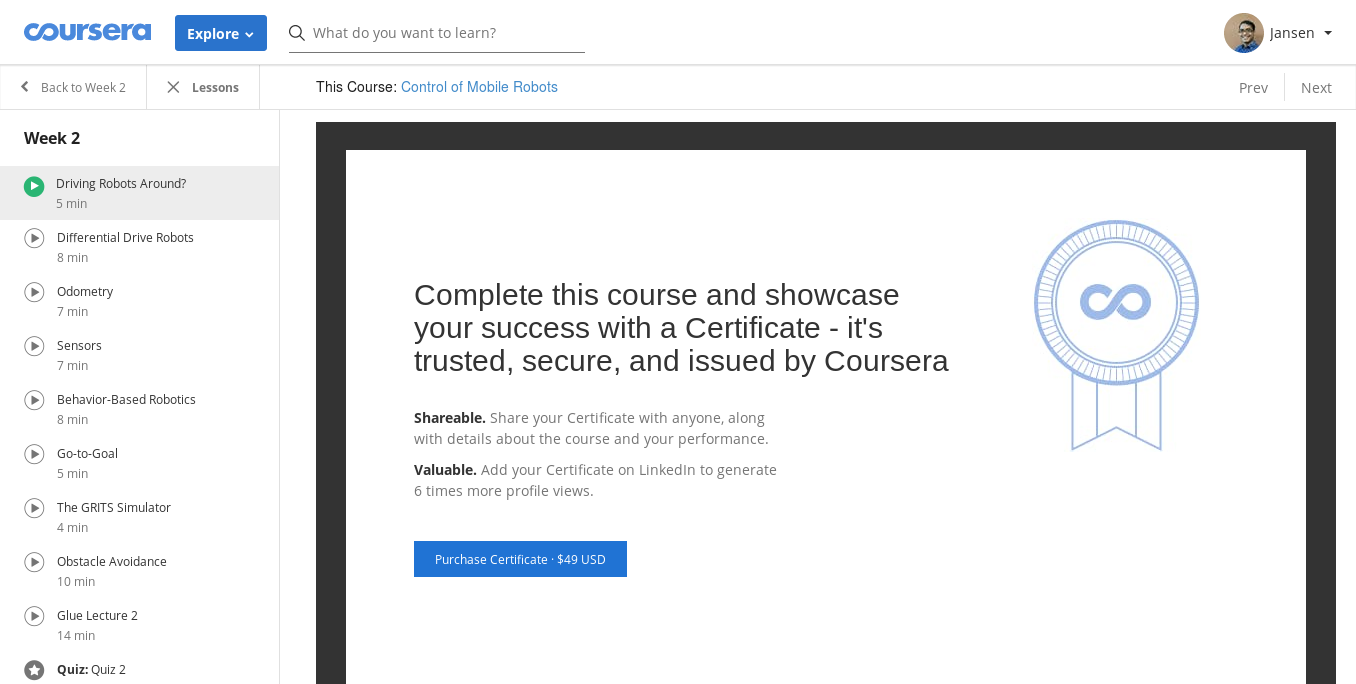

In [98]:
screenshot()

## Manually Calling `mp4_downloader`

In case you need to manually call `mp4_downloader` here is an example:

In [99]:
mp4_downloader('201',
               'Lecture Driving Robots Around?', 
               '/learn/mobile-robot/lecture/4HvCW/driving-robots-around')


video playing will be paused in 10 seconds...
requesting to download...
downloading...100.00%

## Close Browser After Download

In [42]:
browser.quit()